
Demos - Geo - 5 Visualizations with Python to Show Simultaneous Changes in Geospatial Data - Part 1
===================================================================================================


# References
* Source: [Medium - 5 Visualizations with Python to Show Simultaneous Changes in Geospatial Data](https://towardsdatascience.com/5-visualizations-with-python-to-show-simultaneous-changes-in-geospatial-data-ddc2eaab9d78)
  + Date: Nov. 2023
  + Author: Boriharn K.
* [GitHub - Geojson-XYZ](https://github.com/geojson-xyz)
* [IBM - What is geospatial data?](https://www.ibm.com/topics/geospatial-data)
* [Wikipedia - List of U.S. states and territories by income](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income)
* [Wikipedia - Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map)

## DataBricks notebooks
* [Notebook - Demos - Geo - Show Simultaneous Changes in Geospatial Data - Part 1 (this notebook)](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-show-simultaneous-changes-in-geospatial-data-1_2.ipynb)
* [Notebook - Demos - Geo - Show Simultaneous Changes in Geospatial Data - Part 2](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-show-simultaneous-changes-in-geospatial-data-2_2.ipynb)
* [Notebook - Demos - Geo - Python Contextily package](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-python-contextily-package.ipynb)
* [Notebook - Demos - Geo - Spatial projections](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-spatial-projections.ipynb)

## Contextily
* Contextily home page: https://contextily.readthedocs.io/en/latest
* [Introduction guide to contextily — contextily 1.1.0 documentation](https://contextily.readthedocs.io/en/latest/intro_guide.html)

## GeoPandas
* GeoPandas home page: https://geopandas.org/en/stable/
* GitHub page: https://github.com/geopandas/geopandas


In [0]:
%pip install geopandas contextily lxml imageio

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached geopandas-0.14.1-py3-none-any.whl (1.1 MB)
  Using cached contextily-1.4.0-py3-none-any.whl (16 kB)
  Using cached lxml-4.9.4-cp310-cp310-manylinux_2_28_x86_64.whl (7.9 MB)
  Using cached imageio-2.33.1-py3-none-any.whl (313 kB)
  Using cached shapely-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
  Using cached pyproj-3.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached fiona-1.9.5-cp310-cp310-manylinux2014_x86_64.whl (15.7 MB)
  Using cached xyzservices-2023.10.1-py3-none-any.whl (56 kB)
  Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
  Using cached rasterio-1.3.9-cp310-cp310-manylinux2014_x86_64.whl (20.6 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached geo

In [0]:
dbutils.library.restartPython()

In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4417673118071346>, line 3
      1 import numpy as np
      2 import pandas as pd
----> 3 import geopandas as gpd
      4 import matplotlib.pyplot as plt
      5 import seaborn as sns

ModuleNotFoundError: No module named 'geopandas'


# Getting data
## Geometry data
Start with importing libraries. We will mainly work with [GeoPandas](https://geopandas.org/en/stable/),
a useful and easy-to-use library for plotting geospatial data.

Next, the geospatial information can be obtained from geojson.xyz,
an open-source website that provides access to GeoJSON data for web mapping examples and experiments.

The geometry data that we are going to use are the [boundaries of the states](https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson)
in the western United States. The code below shows how to get the
[geometry data](https://geojson.io/#map=2.61/48.23/-119.38), excluding Hawaii and Alaska.

This region will be the main area in this article. If you want to select different states,
feel free to modify the list below.

In [0]:
#https://geojson.xyz/
w_coast = ['Arizona', 'California', 'Idaho',
           'Montana', 'Nevada', 'New Mexico',
           'Oregon', 'Utah', 'Washington', 'Wyoming']
url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson'
df = gpd.read_file(url)
df = df[df.name.isin(w_coast)][['name','geometry']]   #select columns
# Before getting the centroid, the data-frame has to first be projected, here using CEA (https://proj.org/operations/projections/cea.html)
df_centroid = df.to_crs('+proj=cea').centroid
df['centroid'] = df_centroid                          #get centroids
df['lon'] = [i.xy[0][0] for i in df_centroid]         #get longitude
df['lat'] = [i.xy[1][0] for i in df_centroid]         #get latitide
df.head()

name  ...           lat
1     Montana  ...  4.645298e+06
4       Idaho  ...  4.435922e+06
5  Washington  ...  4.671604e+06
6     Arizona  ...  3.571006e+06
7  California  ...  3.830064e+06

[5 rows x 5 columns]


Now that we have the geometries, let's plot the geospatial data.

A base map can be added as a background using the
[contextily library](https://contextily.readthedocs.io/en/latest/intro_guide.html)
to make the chart look realistic. The method is shown in the code below.


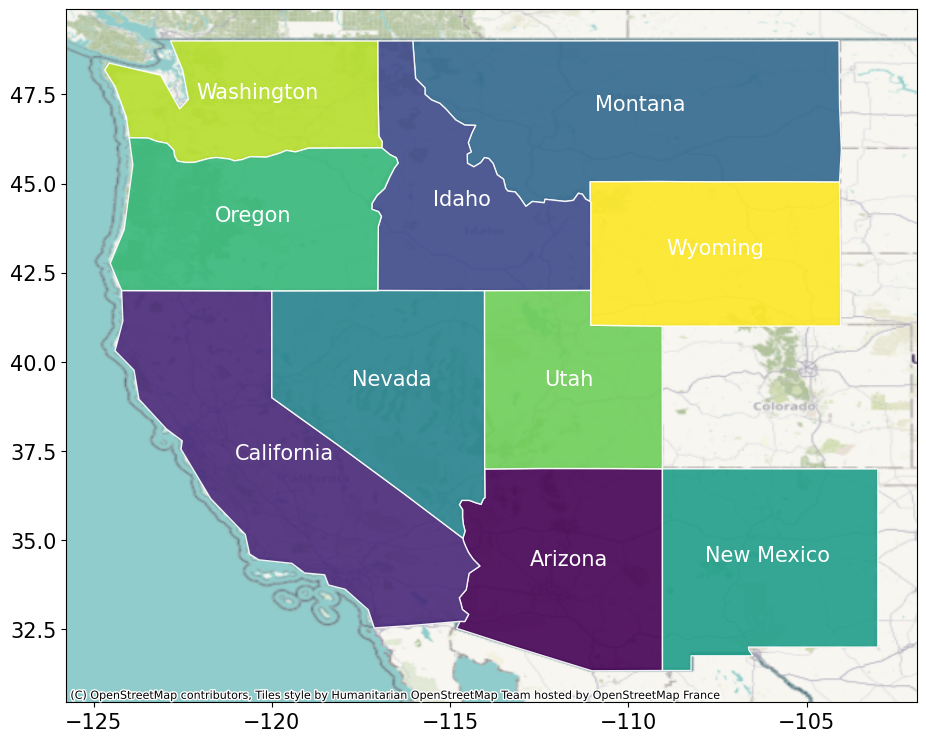

In [0]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(18, 9))
df.plot(column ='name', alpha=0.9, legend=False,      #plotting geometry data
        edgecolor = 'white', cmap='viridis', ax=ax)
df.apply(lambda x: ax.annotate(text = x['name'],      #annotations
                               xy = x.geometry.centroid.coords[0],
                               color = 'white',
                               ha = 'center'), axis = 1)
ax = contextily.add_basemap(ax, crs=df.crs.to_string())
plt.show()


## Data values
To show that the methods in this article can be applied to real-world data, 'U.S. states and territories by income' information on [Wikipedia](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income) will be used as an example for expressing annual changes in data values.

The data are used under the [CC BY-SA 4.0 International license](https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_Creative_Commons_Attribution-ShareAlike_4.0_International_License).

The information can be downloaded with just a few lines of code using the
[Panda's `read_html()` function](https://pandas.pydata.org/docs/reference/api/pandas.read_html.html).
Please note that the retrieved table has no information from the year 2020.

In [0]:
df_w = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income', 
                    match='States and territories ranked by median household income') 
df_w = df_w[0].rename(columns={'States and Washington, D.C.':'name'})
df_w = df_w.iloc[:,1:-1]
df_w.head()

name     2021     2019  ...     2012     2011     2010
0     United States  $69,717  $65,712  ...  $51,371  $50,502  $50,046
1  Washington, D.C.  $90,088  $92,266  ...  $66,583  $63,124  $60,903
2          Maryland  $90,203  $86,738  ...  $71,122  $70,004  $68,854
3     Massachusetts  $89,645  $85,843  ...  $65,339  $62,859  $62,072
4        New Jersey  $89,296  $85,751  ...  $69,667  $67,458  $67,681

[5 rows x 12 columns]


Next, the obtained DataFrame will be merged with the previous one.

In [0]:
df_m = pd.merge(df, df_w, on='name')
df_m.head()

name  ...     2010
0     Montana  ...  $42,666
1       Idaho  ...  $43,490
2  Washington  ...  $55,631
3     Arizona  ...  $46,789
4  California  ...  $57,708

[5 rows x 16 columns]


The median household income values must be converted into integers since the data values obtained are in string format. By the way, the values in string format are kept for annotating the output charts.

In [0]:
y_list = [str(i) for i in list(range(2010,2022))]
y_list.remove('2020')

for i in y_list:
    df_m[str(i)+'_v'] = df_m[i].apply(lambda x: int(str(x).replace('$','').replace(',','')))
df_m.head()

name  ... 2021_v
0     Montana  ...  63249
1       Idaho  ...  66474
2  Washington  ...  84247
3     Arizona  ...  69056
4  California  ...  84907

[5 rows x 27 columns]


# Visualization
This article will guide with 5 chart ideas to show simultaneous changes in geospatial data.

Let's get started!!

## 1. Using spatial areas and colors with Choropleth maps
A Choropleth map is a typical spatial chart that displays colors in accordance with geographic characteristics. By combining multiple maps, we can express the changes over time.

Starting with the code below, the loop function will be applied to plot the choropleth map yearly. Besides color mapping, annotating data values can help show the progress of the median income values.

Please note that the charts obtained will be saved onto your computer for importing in the next step.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

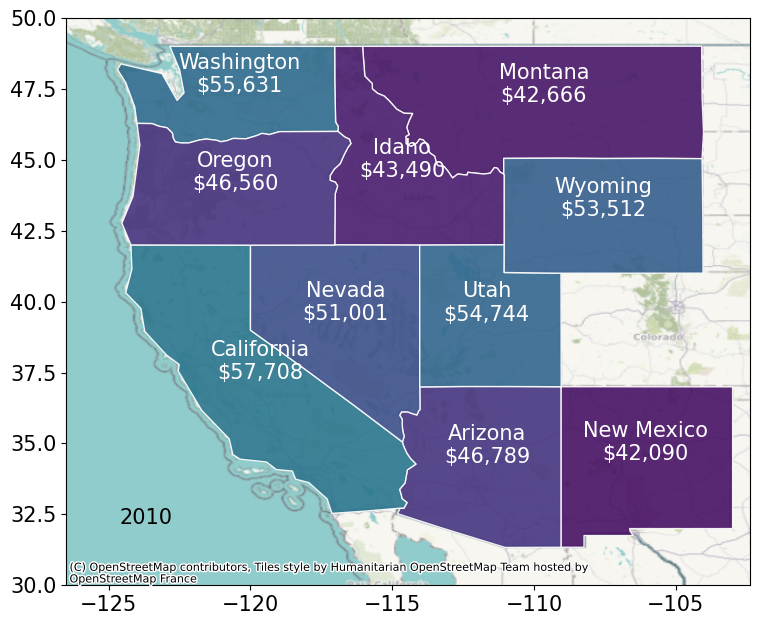

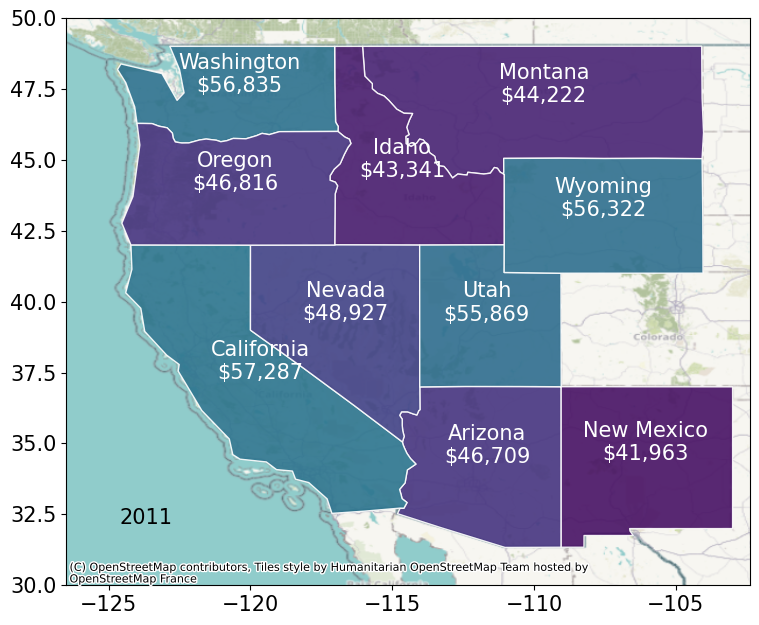

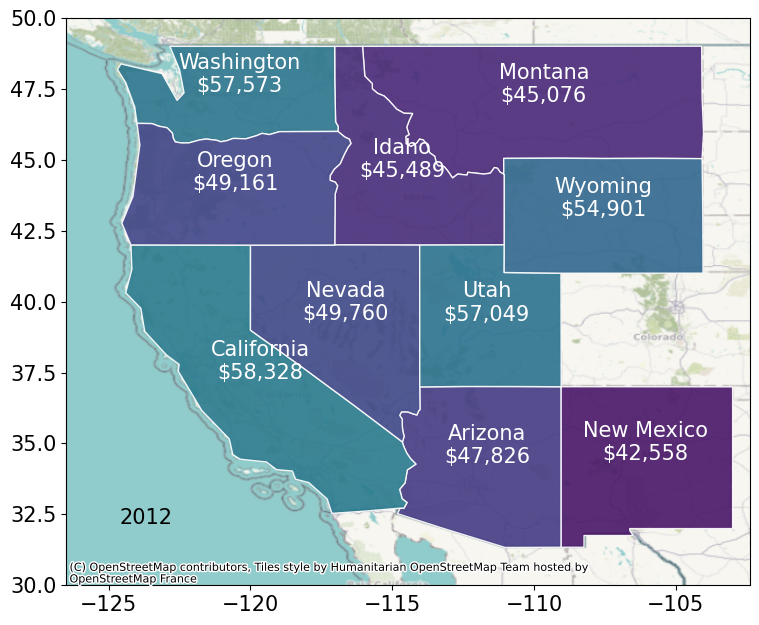

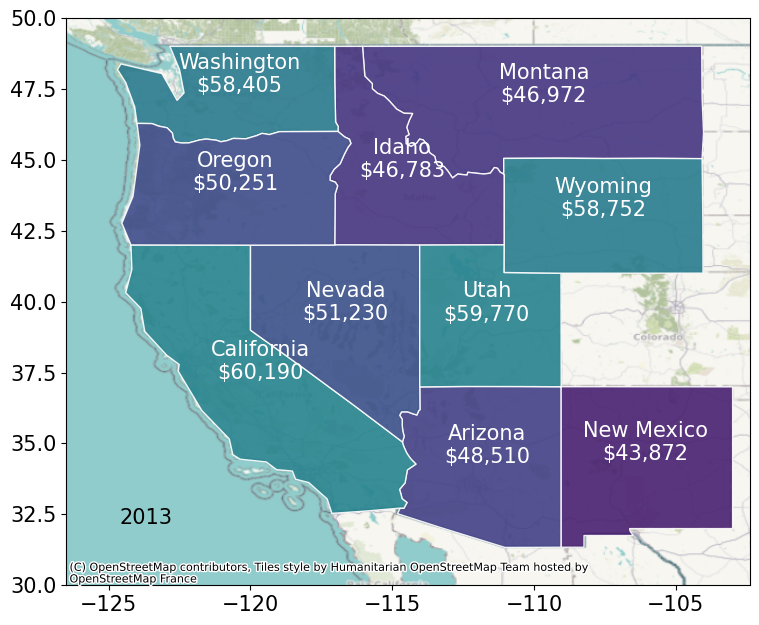

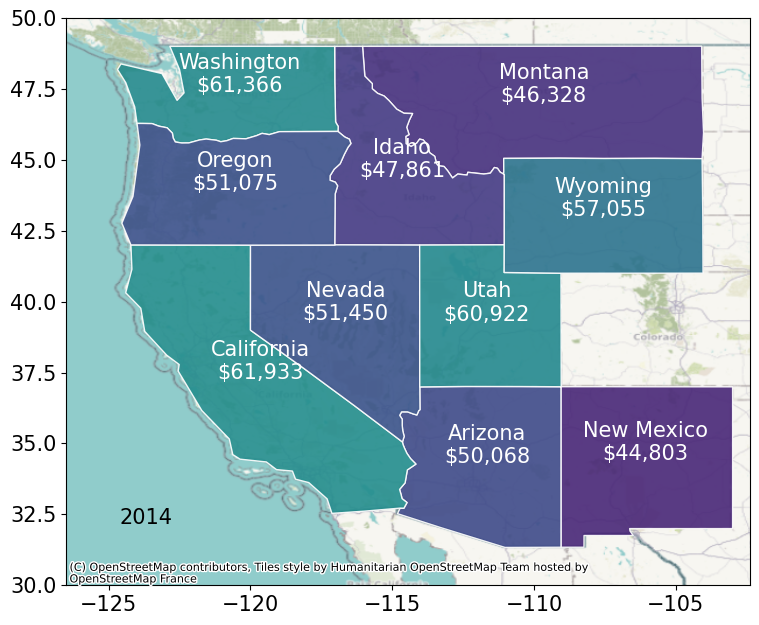

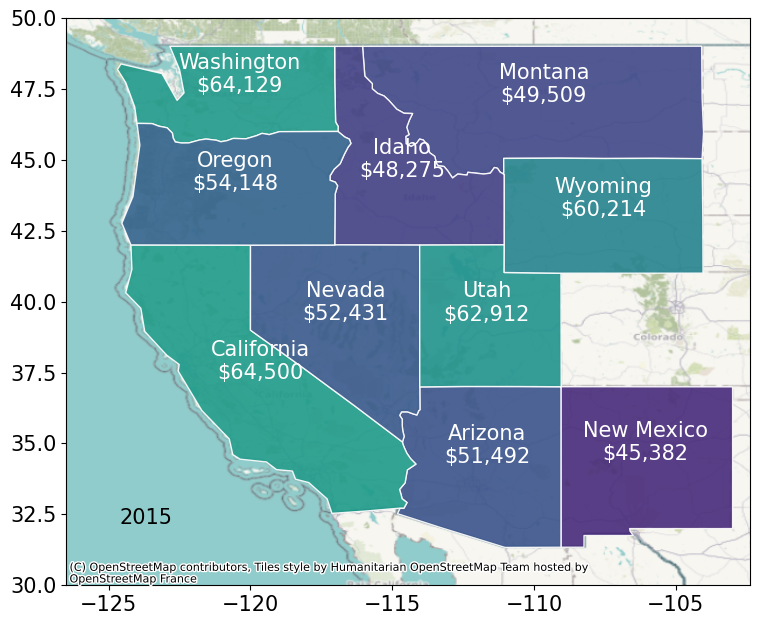

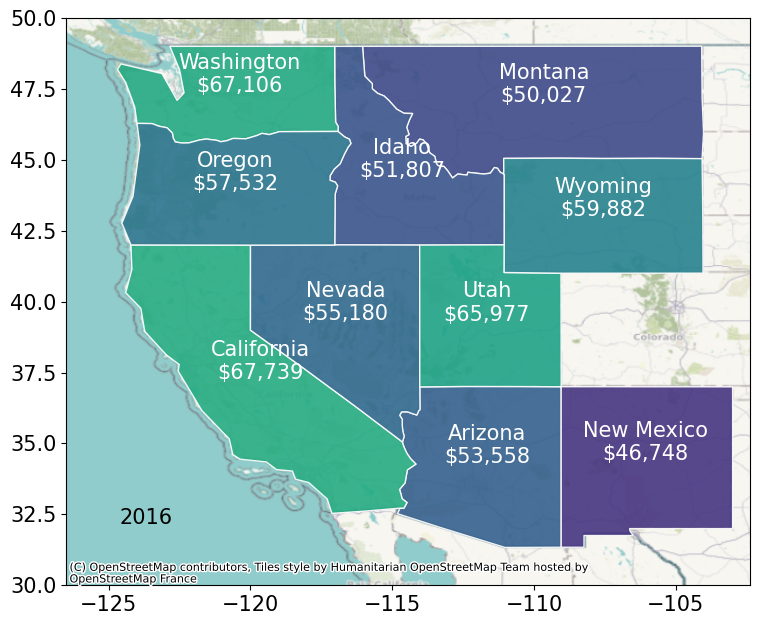

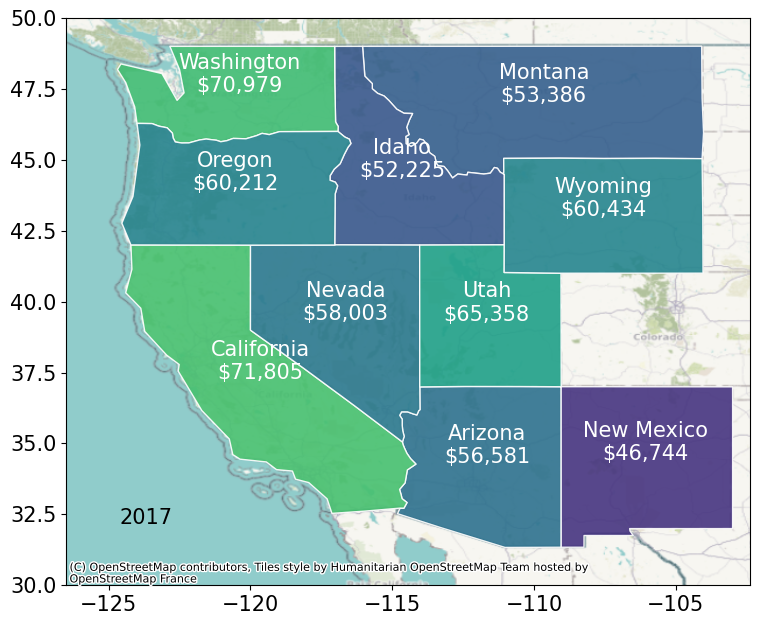

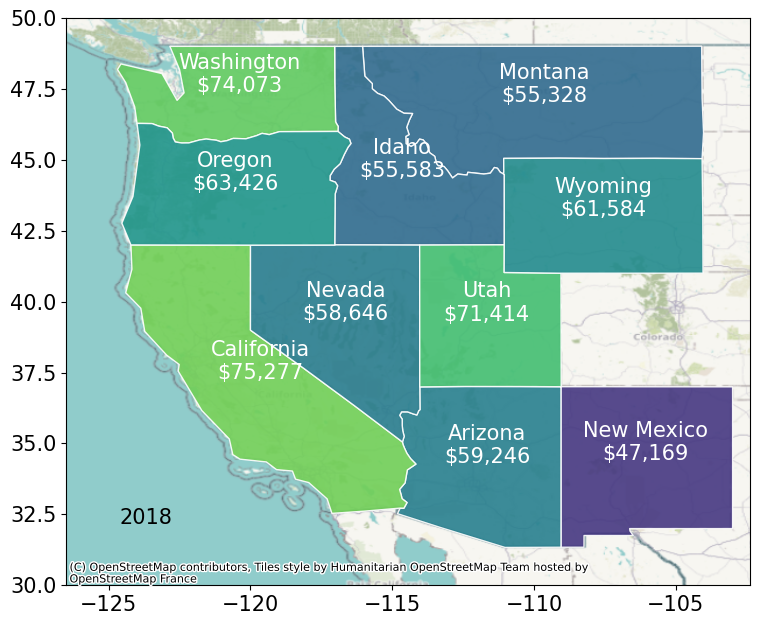

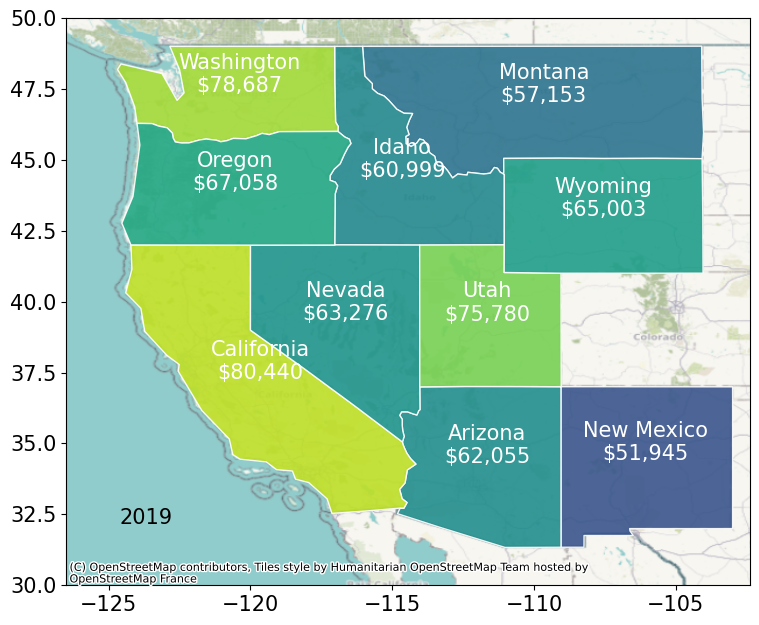

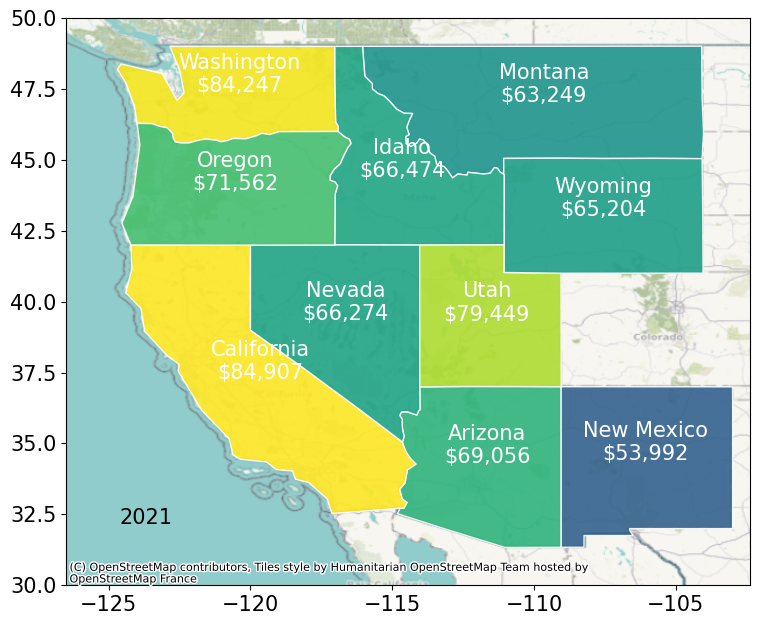

In [0]:
v_list = [i+'_v' for i in y_list]
for year,val in zip(y_list, v_list):
    ax = df_m.plot(column = val,                          #plotting choropleth maps
                   edgecolor = 'white',
                   vmin = 40000, vmax = 85000, alpha=0.9,
                   figsize = (9, 6.5), cmap='viridis',
                   legend=False)
    ax.set_xlim(-126.5, -102.4)
    ax.set_ylim(30, 50)
    df_m.apply(lambda x: ax.annotate(text = x['name'] +'\n'+ x[year],    #annotaion
                                     color = 'white',
                                     xy = x.geometry.centroid.coords[0],
                                     ha = 'center'), axis = 1)
    ax = contextily.add_basemap(ax, crs=df_m.crs.to_string())
    plt.legend(title=year, frameon=False,
               bbox_to_anchor=(0.05, 0.05), loc='lower left')
    plt.tight_layout()
    plt.savefig('choropleth_'+year+'.png')


Now that we already have multiple charts, the following methods are ideas for combining them.

### 1.1 Creating a photo collage
The first idea is to combine the charts all together as a photo collage. This can be considered a good choice for creating an infographic.

Let's define a function for doing the task. I found this useful code and method to create a photo collage from
[this link on Stack Overflow](https://stackoverflow.com/questions/35438802/making-a-collage-in-pil).


In [0]:
from PIL import Image
import imageio

def get_collage(cols_n, rows_n, width, height, input_sname, save_name):
    c_width = width//cols_n
    c_height = height//rows_n
    size = c_width, c_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    
    for p in input_sname:
        im = Image.open(p)
        im.thumbnail(size)
        ims.append(im)
    i, x, y = 0, 0, 0
    
    for col in range(cols_n):
        for row in range(rows_n):
            print(i, x, y)
            try:
                new_im.paste(ims[i], (x, y))
                i += 1
                y += c_height
            except IndexError:
                pass
        x += c_width
        y = 0
    new_im.save(save_name)


Next, the charts will be imported and combined with the defined function.

In [0]:
%sh

mkdir -p /dbfs/FileStore/images/demos/geo

In [0]:
# output width = number of columns * figure width
# output height = number of rows * figure height
get_collage(3, 4, 900*3, 650*4,
            ['choropleth_'+y+'.png' for y in y_list],
            '/dbfs/FileStore/images/demos/geo/choropleth_collage.png')

0 0 0
1 0 650
2 0 1300
3 0 1950
4 900 0
5 900 650
6 900 1300
7 900 1950
8 1800 0
9 1800 650
10 1800 1300
11 1800 1950


In [0]:
%sh ls -lFh /dbfs/FileStore/images/demos/geo/

total 2.8M
-rwxrwxrwx 1 nobody nogroup 615K Nov  7 14:10 choropleth.gif*
-rwxrwxrwx 1 nobody nogroup 2.2M Nov  7 14:07 choropleth_collage.png*



![Choropleth collage](files/images/demos/geo/choropleth_collage.png)



The photo collage can show and help compare the simultaneous changes in geospatial data. From the result, it can be easily distinguished that California has the highest median household income, and New Mexico has the lowest one over time.



### 1.2 Creating an animation
Besides putting the maps next to each other, we can gather them in order to create an animation. If the media you use allows displaying moving pictures in a GIF file format, this can be a good choice for catching the reader's attention.


In [0]:
img = [Image.open('choropleth_'+y+'.png') for y in y_list]    #read the PNG files
imageio.mimsave('/dbfs/FileStore/images/demos/geo/choropleth.gif', img, duration=0.6)          #export the GIF file


![Animated Choropleth](files/images/demos/geo/choropleth.gif)


See the follow up on
[Notebook - Demos - Geo - Show Simultaneous Changes in Geospatial Data - Part 2](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-show-simultaneous-changes-in-geospatial-data-2_2.ipynb)